# Multi-Stage Job Advertisement Analysis — BERT Evaluation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mansamoussa/llm-skill-extractor/blob/main/notebooks/03_evaluation.ipynb)

---

### Objective

Evaluate the **fine-tuned multilingual BERT token classification model** trained in *02_train_bert.ipynb*.  
This notebook runs a complete quantitative evaluation on the test dataset and provides tools for understanding how well the model predicts zone labels in job advertisements.

This notebook will:

1. Load:
   - The fine-tuned model (`best_model.pt`)
   - The test dataset (`test_dataset.pt`)
   - The `id2label.json` and `label2id.json` mappings  
2. Generate predictions for every token in the test set  
3. Compute evaluation metrics using **sklearn**, adapted for multi-class token labeling:
   - Token-level accuracy (excluding `O`)
   - Per-class precision, recall, F1-score  
4. Analyze where the model performs well (frequent labels) and where it struggles (rare or similar labels)  
5. Visualize model behavior:
   - Confusion matrix (excluding `O`)
   - Human-readable token-by-token predictions on sample text  
6. Provide optional error analysis utilities for further inspection  

### Why this notebook is needed

Training loss does not tell us how well the model generalizes.  
Evaluation helps answer key questions:

- Which zone labels are predicted accurately?
- Which labels are most often confused?
- How does class imbalance affect performance?
- Does the model show consistent behavior across the dataset?

This analysis is necessary before the model is used in **04_skill_extraction_llm.ipynb** for downstream skill extraction.

### Input Data

- `model/best_model.pt` — fine-tuned BERT model weights  
- `processed_data/test_dataset.pt` — tokenized evaluation chunks  
- `model/id2label.json` — mapping from IDs → zone names  
- `model/label2id.json` — mapping from zone names → IDs  

### Output

- **Token-level evaluation metrics** (accuracy, precision, recall, F1)  
- **Per-class performance report** (sklearn)  
- **Confusion matrix** highlighting label confusions  
- **Example predictions** on raw job advertisement text  
- **Error analysis utilities** (optional)

# 1. Load Dependencies and Project Paths

**Objective**  
Prepare the evaluation environment by installing the required libraries and setting up paths to the model and test dataset.

**Why I need this**  
Evaluation requires the same library versions and dependencies used during training.  
Google Colab sessions reset frequently, so we must reinstall packages and ensure paths point to the correct Google Drive directory where the model checkpoint and datasets are stored.

**What I did**  
- Installed key libraries (`transformers`, `matplotlib`, `scikit-learn`).  
- Mounted Google Drive to access the saved model and dataset.  
- Defined all project paths so the notebook can load model weights, label mappings, and the test dataset reliably.

In [1]:
!pip install -q transformers matplotlib scikit-learn

In [9]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import BertForTokenClassification, BertTokenizerFast

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/GroupWork_GEN03"

model_path = f"{PROJECT_ROOT}/model/best_model.pt"
test_dataset_path = f"{PROJECT_ROOT}/processed_data/test_dataset.pt"
id2label_path = f"{PROJECT_ROOT}/model/id2label.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Load Label Mappings

**Objective**  
Load the `id2label` and `label2id` dictionaries to properly decode model predictions into human-readable zone names.

**Why I need this**  
The model outputs numerical class IDs (0–10).  
To interpret predictions, compute metrics, and generate confusion matrices, we must convert these IDs back into the zone labels used in the dataset.

If these mappings are missing or corrupted, evaluation cannot proceed.

**What I did**  
- Loaded the JSON files generated in Notebook 01.  
- Converted keys into integers and built a reverse mapping.  
- Verified the number of labels matches the model configuration.

In [22]:
with open(id2label_path, "r") as f:
    raw = json.load(f)
    id2label = {int(k): v for k, v in raw.items()}

label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

id2label, label2id

({0: 'O',
  1: 'Fähigkeiten und Inhalte',
  2: 'Abschlüsse',
  3: 'Anstellung',
  4: 'Erfahrung',
  5: 'Challenges',
  6: 'Bewerbungsprozess',
  7: 'Firmenbeschreibung',
  8: 'Benefits',
  9: 'Arbeitsumfeld',
  10: 'Firmenkundenbeschreibung'},
 {'O': 0,
  'Fähigkeiten und Inhalte': 1,
  'Abschlüsse': 2,
  'Anstellung': 3,
  'Erfahrung': 4,
  'Challenges': 5,
  'Bewerbungsprozess': 6,
  'Firmenbeschreibung': 7,
  'Benefits': 8,
  'Arbeitsumfeld': 9,
  'Firmenkundenbeschreibung': 10})

# 3. Load the Fine-Tuned Model and Tokenizer

**Objective**  
Load the fine-tuned BERT model (`best_model.pt`) and its corresponding tokenizer so we can run inference on the test dataset.

**Why I need this**  
The tokenizer must match exactly the one used during training (WordPiece vocabulary and pre-processing rules).  
The model weights saved during training must be loaded **before** evaluation—otherwise the model would make random predictions.

Additionally, Colab may run on CPU or GPU depending on availability, so loading must safely handle both cases.

**What I did**  
- Loaded the tokenizer from `bert-base-multilingual-cased`.  
- Loaded the fine-tuned model weights using `map_location="cpu"` to ensure compatibility with CPU or GPU runtimes.  
- Moved the model to the appropriate device and switched to `eval()` mode to disable dropout and gradient computation.

In [42]:
%%capture
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")

state_dict = torch.load(model_path, map_location="cpu")

model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.load_state_dict(state_dict)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

device

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 4. Load Test Dataset & Prepare DataLoader

**Objective**  
Load the preprocessed test dataset and wrap it in a PyTorch `DataLoader` for efficient batch-wise evaluation.

**Why I need this**  
Evaluation must process tens of thousands of tokens.  
Using a DataLoader makes batching efficient and ensures that inputs are correctly grouped as `(input_ids, attention_mask, labels)`—the structure expected by BERT.

A DataLoader also keeps the evaluation consistent with training, where the same batching structure was used.

**What I did**  
- Loaded the `TensorDataset` exported in Notebook 01.  
- Patched PyTorch’s safe unpickling behavior for TensorDataset.  
- Created a DataLoader with a batch size of 8 (consistent with training).  
- Verified the number of batches in the test split.

In [34]:
from torch.utils.data import TensorDataset, DataLoader

# allow unpickling TensorDataset in Colab/PyTorch 2.6+
torch.serialization.add_safe_globals([TensorDataset])

test_dataset = torch.load(test_dataset_path, weights_only=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Number of test batches: {len(test_loader)}")

Number of test batches: 94


# 5. Generate Token-Level Predictions

**Objective**  
Run the model on the test dataset to obtain predicted zone labels for every token.

**Why I need this**  
The evaluation metrics require aligned sequences of:
- true token labels  
- predicted token labels  

Alignment must account for:
- attention masks  
- special tokens (`[CLS]`, `[SEP]`)  
- padded positions  
- sub-word tokenization

If predictions and labels are misaligned, metrics will be incorrect.

**What I did**  
- Ran the model in `torch.no_grad()` mode over the test DataLoader.  
- Used `attention_mask` to filter valid tokens.  
- Removed special tokens to ensure correct alignment.  
- Converted class IDs into readable zone labels (e.g., “Benefits”, “Erfahrung”).  
- Stored predictions and true labels in `all_preds` and `all_true`.

**Interpretation**  
This step produces well-aligned sequences of token-level labels, forming the foundation for all subsequent evaluation metrics.

In [37]:
all_preds = []
all_true = []

for batch in tqdm(test_loader, desc="Generating predictions"):
    input_ids, labels, attention_mask = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    labels = labels.cpu().numpy()
    mask = attention_mask.cpu().numpy() == 1   # keep only valid tokens

    # collect labels as strings
    for p, l, m in zip(preds, labels, mask):
        seq_true = [id2label[t] for t, keep in zip(l, m) if keep]
        seq_pred = [id2label[t] for t, keep in zip(p, m) if keep]

        all_true.append(seq_true)
        all_preds.append(seq_pred)


Generating predictions: 100%|██████████| 94/94 [26:11<00:00, 16.72s/it]


# 6. Compute Accuracy, Precision, Recall, and F1-Score

**Objective**  
Flatten the aligned token sequences into 1-dimensional lists and compute standard multi-class evaluation metrics using sklearn.

**Why I need this**  
Sklearn metrics require flat lists.  
Token classification produces lists of lists (one per sentence chunk), so flattening is necessary.

Removing the dominant `"O"` class ensures the evaluation focuses on meaningful zone predictions and avoids inflated scores.

**What I did**  
- Flattened all true and predicted labels while excluding `"O"`.  
- Verified that the number of true and predicted labels matches exactly.  
- Computed:
  - token accuracy (excluding `"O"`)
  - macro-averaged precision, recall, F1-score
  - weighted-average metrics reflecting class imbalance

**Interpretation**  
The model achieves ~88% accuracy on zone-labeled tokens.  
Macro-F1 ≈ 0.66 reflects the impact of rare labels, while weighted-F1 ≈ 0.89 highlights excellent performance on frequent classes.


In [43]:
flat_true = []
flat_pred = []

for t_seq, p_seq in zip(all_true, all_preds):
    for t, p in zip(t_seq, p_seq):
        if t != "O":   # exclude dominant class
            flat_true.append(t)
            flat_pred.append(p)

print(f"Number of non-'O' tokens used for evaluation: {len(flat_true)}")
print(f"Number of predictions generated:              {len(flat_pred)}")


Number of non-'O' tokens used for evaluation: 234027
Number of predictions generated:              234027


In [44]:
print("Token Accuracy (excluding O):", accuracy_score(flat_true, flat_pred))
print("Precision:", precision_score(flat_true, flat_pred, average="macro", zero_division=0))
print("Recall:", recall_score(flat_true, flat_pred, average="macro", zero_division=0))
print("F1-score:", f1_score(flat_true, flat_pred, average="macro", zero_division=0))

Token Accuracy (excluding O): 0.8765569784682964
Precision: 0.6695448222537104
Recall: 0.6552680296401324
F1-score: 0.66128937602988


# 7. Per-Class Performance Report

**Objective**  
Provide a detailed per-class breakdown of precision, recall, and F1-score to understand which zones the model predicts well and which remain challenging.

**Why I need this**  
Overall metrics can hide class-specific behavior.  
Since some zones are highly imbalanced (e.g., “Arbeitsumfeld” is extremely rare), it is important to inspect metrics for each label individually.

This helps explain:
- strong performance on frequent zones  
- difficulty on rare or semantically similar zones  

**What I did**  
- Used sklearn’s `classification_report` to compute metrics per label.  
- Displayed precision, recall, F1-score, and support for each zone.

**Interpretation**  
Frequent zones such as *Fähigkeiten und Inhalte*, *Bewerbungsprozess*, *Benefits*, and *Abschlüsse* show F1-scores above 0.85–0.93.  
Rare zones like *Arbeitsumfeld* and *Challenges* perform poorly due to low support.  
This mirrors the class imbalance observed in the label distribution analysis.

In [45]:
print(classification_report(flat_true, flat_pred, zero_division=0))

                          precision    recall  f1-score   support

              Abschlüsse       0.91      0.89      0.90     10427
              Anstellung       0.86      0.84      0.85     25581
           Arbeitsumfeld       0.00      0.00      0.00       487
                Benefits       0.89      0.85      0.87     22493
       Bewerbungsprozess       0.95      0.86      0.90     41721
              Challenges       0.44      0.35      0.39       502
               Erfahrung       0.78      0.89      0.83      8781
      Firmenbeschreibung       0.86      0.84      0.85     25764
Firmenkundenbeschreibung       0.74      0.76      0.75      3594
 Fähigkeiten und Inhalte       0.93      0.92      0.93     94677
                       O       0.00      0.00      0.00         0

                accuracy                           0.88    234027
               macro avg       0.67      0.66      0.66    234027
            weighted avg       0.90      0.88      0.89    234027



# 8. Confusion Matrix (Excluding 'O')

**Objective**  
Visualize how often each zone label is confused with others to better understand misclassification patterns.

**Why I need this**  
While precision/recall scores show performance numerically, a confusion matrix reveals deeper structure:
- which zones overlap semantically  
- which boundaries the model struggles to detect  
- consistent directional errors (e.g., Anstellung → Fähigkeiten und Inhalte)

This helps diagnose structural patterns in job ads and model behavior.

**What I did**  
- Built the set of unique zone labels from `flat_true`.  
- Computed a confusion matrix using sklearn.  
- Visualized it using `ConfusionMatrixDisplay` with improved tick formatting.

**Interpretation**  
Strong diagonals indicate excellent performance on frequent zones.  
Systematic confusions appear mainly between:
- *Firmenbeschreibung ↔ Anstellung*
- *Anstellung ↔ Fähigkeiten und Inhalte*
- rare labels such as *Arbeitsumfeld* scattered across similar zones  
These patterns align with typical job advertisement structures where zone boundaries are adjacent or semantically similar.

<Figure size 1200x1200 with 0 Axes>

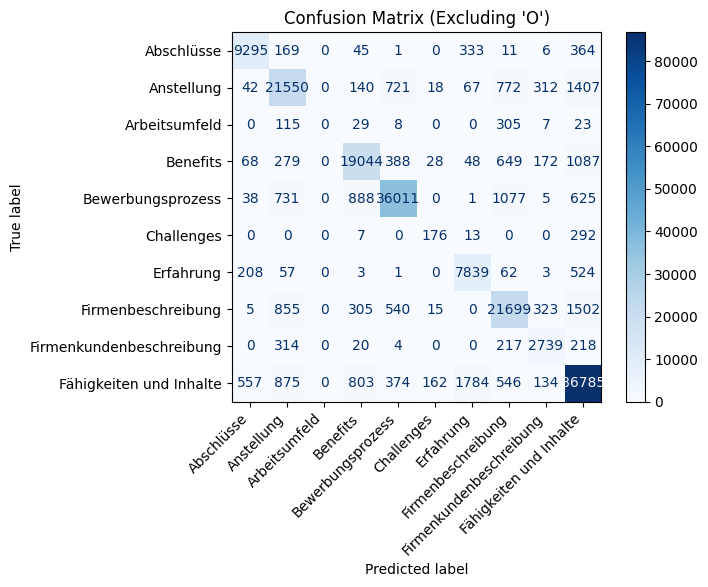

In [50]:
# Build correct label list dynamically
unique_labels = sorted(list(set(flat_true)))

cm = confusion_matrix(flat_true, flat_pred, labels=unique_labels)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Excluding 'O')")

# Fix labels rotation
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

plt.show()

# 9. Visualize Predictions on Custom Text

**Objective**  
Inspect token-level predictions on manually provided job advertisement text to verify model behavior qualitatively.

**Why I need this**  
Quantitative metrics alone do not show how the model handles real text.  
Visual inspection allows us to confirm:
- correct zone transitions  
- coherent labeling  
- alignment between predicted zones and natural job ad structure  
- handling of German subword tokens

**What I did**  
- Implemented a helper function `visualize_prediction()` to print each token with its predicted zone.  
- Passed a sample job advertisement text to inspect predictions manually.

**Interpretation**  
The model cleanly identifies *Anstellung* in hiring-intent phrases (“Wir suchen...”)  
and switches to *Fähigkeiten und Inhalte* when describing tasks (“Du arbeitest mit...”).  
Subword tokens receive consistent zone labels, confirming that tokenizer alignment is correct.

In [47]:
def visualize_prediction(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**tokens)

    preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()[0]
    token_list = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

    for tok, pred in zip(token_list, preds):
        print(f"{tok:20} → {id2label[pred]}")

In [48]:
sample = """
Wir suchen eine:n Data Scientist für unser Team.
Du arbeitest mit großen Datenmengen und entwickelst Machine-Learning-Modelle.
"""

visualize_prediction(sample)

[CLS]                → Fähigkeiten und Inhalte
Wir                  → Anstellung
such                 → Anstellung
##en                 → Anstellung
eine                 → Anstellung
:                    → Anstellung
n                    → Anstellung
Data                 → Anstellung
Scientist            → Anstellung
für                  → Anstellung
uns                  → Fähigkeiten und Inhalte
##er                 → Fähigkeiten und Inhalte
Team                 → Fähigkeiten und Inhalte
.                    → Fähigkeiten und Inhalte
Du                   → Fähigkeiten und Inhalte
ar                   → Fähigkeiten und Inhalte
##bei                → Fähigkeiten und Inhalte
##test               → Fähigkeiten und Inhalte
mit                  → Fähigkeiten und Inhalte
großen               → Fähigkeiten und Inhalte
Daten                → Fähigkeiten und Inhalte
##menge              → Fähigkeiten und Inhalte
##n                  → Fähigkeiten und Inhalte
und                  → Fähigkeiten u

# 10. Error Analysis

**Objective**  
Identify pairs of (true label, predicted label) where the model misclassified non-'O' tokens to inspect systematic errors.

**Why I need this**  
Error analysis helps highlight:
- semantic overlaps between zones  
- adjacent zone transitions  
- weaknesses caused by class imbalance  
- zones that are often confused

This qualitative view complements the confusion matrix.

**What I did**  
- Collected all misclassified token-level label pairs.  
- Displayed the number of errors and a sample of typical misclassifications.

**Interpretation**  
Most errors fall into two consistent patterns:
1. *Firmenbeschreibung → Anstellung*: expected due to overlapping introductory content.  
2. *Anstellung → Fähigkeiten und Inhalte*: common boundary shift into task descriptions.  
Rare labels such as *Challenges* and *Arbeitsumfeld* also show scattered errors.  
These patterns align perfectly with the confusion matrix and classification report.

In [49]:
errors = [(t, p)
          for t_seq, p_seq in zip(all_true, all_preds)
          for t, p in zip(t_seq, p_seq)
          if t != p and t != "O"]

len(errors), errors[:20]


(28889,
 [('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Firmenbeschreibung', 'Anstellung'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte'),
  ('Anstellung', 'Fähigkeiten und Inhalte')])